# Insurance Fraud Predictive Model 
By Vy Khanh Pham 

#### Import Packages

In [1]:
# Installed packages -- Data Wrangling
import numpy as np
import pandas as pd
import regex as re
import calendar

# Pandas profiling for fast EDA 
from pandas_profiling import ProfileReport

# Installed packages -- Data Visualization
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns  
from ipywidgets import widgets
import plotly.express as px

# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

from IPython.display import display, Latex, Markdown

# Goal and Overview 

**Problem Statement:**
The data contains different insurance claims, including fraudulent and non-fraudulent claims. 
Build a predictive model to detect whether a claim is fraudulent (1) or not (0).

**Challenges:** 
Selecting useful features.
Making use of qualitative data. 
Dealing with missing data.

**Steps:** 
1. Data Cleaning 
2. Exploratory Data Analysis 
3. Feature Selection and Feature Engineering 
4. Predictive Modeling 
5. Model Evaluation

# Data Cleaning and Preprocessing

In [27]:
# read csv and view 
claims = pd.read_csv("Claims.csv")
claims.head(5)

claimnumber                     name updatetime         lossdate  fault  \
0     42-3069       Collision Rear-end    14:50.4  11/17/2017 1:12    0.0   
1     42-3082  Collision while Backing    18:32.5  11/16/2018 4:17  100.0   
2     42-3083  Collision while Parked     49:28.0  8/30/2017 12:29    0.0   
3     42-3085                   Animal    19:42.9   8/26/2018 0:16    0.0   
4     42-3088    Collision Hit and Run    27:53.3   12/1/2017 0:02    0.0   

   fraud insured_sex  insured_occupation auto_make  months_as_customer  \
0    0.0        male                 6.0     SMART                44.0   
1    1.0        male                 1.0    SUBARU                 1.0   
2    0.0      female                 4.0     SMART                66.0   
3    0.0      female                 5.0     OTHER                38.0   
4    0.0      female                 6.0    SUBARU                 8.0   

  insured_state incident_severity property_damage  bodily_injuries  
0            PA      Major Damage             YES              1.0  
1            CA      Minor Damage               ?              0.0  
2            CA      Minor Damage              NO              2.0  
3            CA      Major Damage               ?              1.0  
4            PA      Minor Damage              NO              0.0

### Columns and Types 

In [28]:
claims.dtypes

claimnumber            object
name                   object
updatetime             object
lossdate               object
fault                 float64
fraud                 float64
insured_sex            object
insured_occupation    float64
auto_make              object
months_as_customer    float64
insured_state          object
incident_severity      object
property_damage        object
bodily_injuries       float64
dtype: object

### Pandas-Profiling for Data Insight

I will be using pandas profiling to gain quick insight into the data, such as how many missing data there are in each column. More information on pandas profiling can be found [Here](https://github.com/pandas-profiling/pandas-profiling).

**Note:** You can install *pandas_profiling* using the pip package manager by running
`!pip install pandas-profiling[notebook]` in this notebook



In [29]:
# Generate the Profiling Report 
profile = ProfileReport(claims, title = "Claims Dataset", html={'style': {'full_width':True}})
profile

##### Duplicates 
We have a total of *43157* observations, *30935* of which are duplicate rows.
* In other words, 73.6% of our data are duplicates
* Action: Remove Duplicates

In [30]:
claims = claims.drop_duplicates()

##### Missing Data 
In the last rows, we can see that there are * a lot * of rows where all columns are none. 
* Claim Number Missing is 30936, one more than the 30935 duplicate rows. The duplicate rows are probably coming from the all null rows. 
* For each column, the number of missing data is roughly around 30935.
* Action: Remove all rows where all columns are Null. We will deal with other null values later accordingly. 

In [31]:
claims = claims.dropna(how="all") # Only drop rows where everything is Null 

##### Missing Data 
In the last rows, we can see that there are * a lot * of rows where all columns are none. 
* Claim Number Missing is 30936, one more than the 30935 duplicate rows. The duplicate rows are probably coming from the all null rows. 
* For each column, the number of missing data is roughly around 30935.
* Action: Remove all rows where all columns are Null. We will deal with other null values later accordingly. 

#### Second Report 

In [32]:
# generate the profile report again now that we've dropped duplicates and removed null. 
profile = ProfileReport(claims, title = "Claims Dataset", html={'style': {'full_width':True}})
profile

### Additional Insights

#### Duplicates and Missing Values 
**Overall**: 

* 0% Duplicate rows 
* 6.7% Missing cells 

**For Columns**: 
* 0.1% missing for `insured_sex`
* 0.9% missing for `insured_occupants`
* 0.2% missing for `auto_make`
* 0.3% missing for `months_as_customer`
* 0.6% missing for `property_damage`
* **91.8%** missing for `bodily_injuries`

The way in which we will deal with missing values will be different accordingly. For example, we see that `bodily_injuries` have a high percentage of missing value of 91.8%. I will look into whether or not bodily injuries would be a useful feature. If not, we will drop the column. 

#### Other Insights 
* From the `Correlations` section, we can see that `fraud` and `months_as_customer` are negatively correlated. 
* There are no correlation between `bodily_injuries` and `fraud`, so it does not appear to be a useful feature. It is not worth it to drop 91.8% of the current dataset we have if it will not contribute to our model. Therefore, I will drop this column entirely. 

### Additional Data Cleaning

Since we have two columns `name` and `auto_make` that are Strings, let's pre-process them in case of misspelling or duplicates due to slight differences. 

In [33]:
claims.head(2)

claimnumber                     name updatetime         lossdate  fault  \
0     42-3069       Collision Rear-end    14:50.4  11/17/2017 1:12    0.0   
1     42-3082  Collision while Backing    18:32.5  11/16/2018 4:17  100.0   

   fraud insured_sex  insured_occupation auto_make  months_as_customer  \
0    0.0        male                 6.0     SMART                44.0   
1    1.0        male                 1.0    SUBARU                 1.0   

  insured_state incident_severity property_damage  bodily_injuries  
0            PA      Major Damage             YES              1.0  
1            CA      Minor Damage               ?              0.0

#### Auto_Make
As we can see, there are `SUBARU` and `SUBUWU` which are essentially the same.

In [34]:
claims['auto_make'].unique()

array(['SMART', 'SUBARU', 'OTHER', 'MERCEDES-BENZ', 'SUZUKI', 'TOYOTA',
       'NISSAN', 'VOLKSWAGEN', 'VOLVO', 'SUBUWU', nan, 'TESLA'],
      dtype=object)

In [35]:
claims['auto_make'] =(claims['auto_make']
                      .str.replace("SUBUWU", "SUBARU")
                      .str.lower())

#### Name

Here, we can see that there is Collision at Intersect and Collision at Intersection,

In [36]:
claims['name'].unique()

array(['Collision Rear-end', 'Collision while Backing',
       'Collision while Parked ', 'Animal', 'Collision Hit and Run',
       'Collision Rearend', 'Collision with Fixed Object', 'Vandalism',
       'Collision Other', 'Collision at Intersection',
       'Comprehensive Other ', 'Glass Only ', 'Collision while Turning ',
       'Theft of Entire Vehicle', 'Collision at Intersect',
       'Impact with Falling/Flying Object', 'Collision while Parking ',
       'Collision Rollaway/Unattended', 'Theft Audio',
       'Collision Solo Accident',
       'All Risk - Mechanical (paint, brakes, all other)',
       'Collision while Changing Lanes', 'Collision with Bicycle',
       'Collision with Pedestrian', 'Collision with Motorcycle ',
       'Collision with Motor Vehicle', 'Fire',
       'Collision with Train or Bus', 'Explosion',
       'Pedestrian/Insured Injury Only ', 'Water', 'Windstorm', 'Hail'],
      dtype=object)

In [37]:
claims['name'] = (claims['name']
                  .str.replace('Collision at Intersection', "Collision at Intersect")
                  .str.lower()
                 )

# Exploratory Data Analysis

### Top 3 Most Frequent Claims 

In [38]:
topThreeClaims = claims['name'].value_counts()[0:3]
topThreeClaims

collision rear-end          2804
glass only                  1707
collision while turning     1464
Name: name, dtype: int64

In [40]:
top3Claims = claims[claims['name'].isin(np.array(topThreeClaims.index))]
# Covert to datetime object 
top3Claims['lossdatetime'] = top3Claims['lossdate'].apply(pd.to_datetime)

#Extract Month and Year 
top3Claims['year'] = top3Claims['lossdatetime'].apply(lambda x: x.year)
top3Claims['month'] = top3Claims['lossdatetime'].apply(lambda x: x.month)

#Grouping and preparing for plotting
top3ClaimsByDate = ( top3Claims[['name','year', 'month', "lossdatetime"]]
                    .groupby(["name", 'year', 'month'])
                    .agg('count')
                    .reset_index())

top3ClaimsByDate['Loss Date'] =( top3ClaimsByDate['month'].apply(lambda x: calendar.month_abbr[x]) 
                                + " " 
                                + top3ClaimsByDate['year'].apply(lambda x: str(x)) 
                               )
top3ClaimsByDate = top3ClaimsByDate.rename(columns={"lossdatetime":"count"})

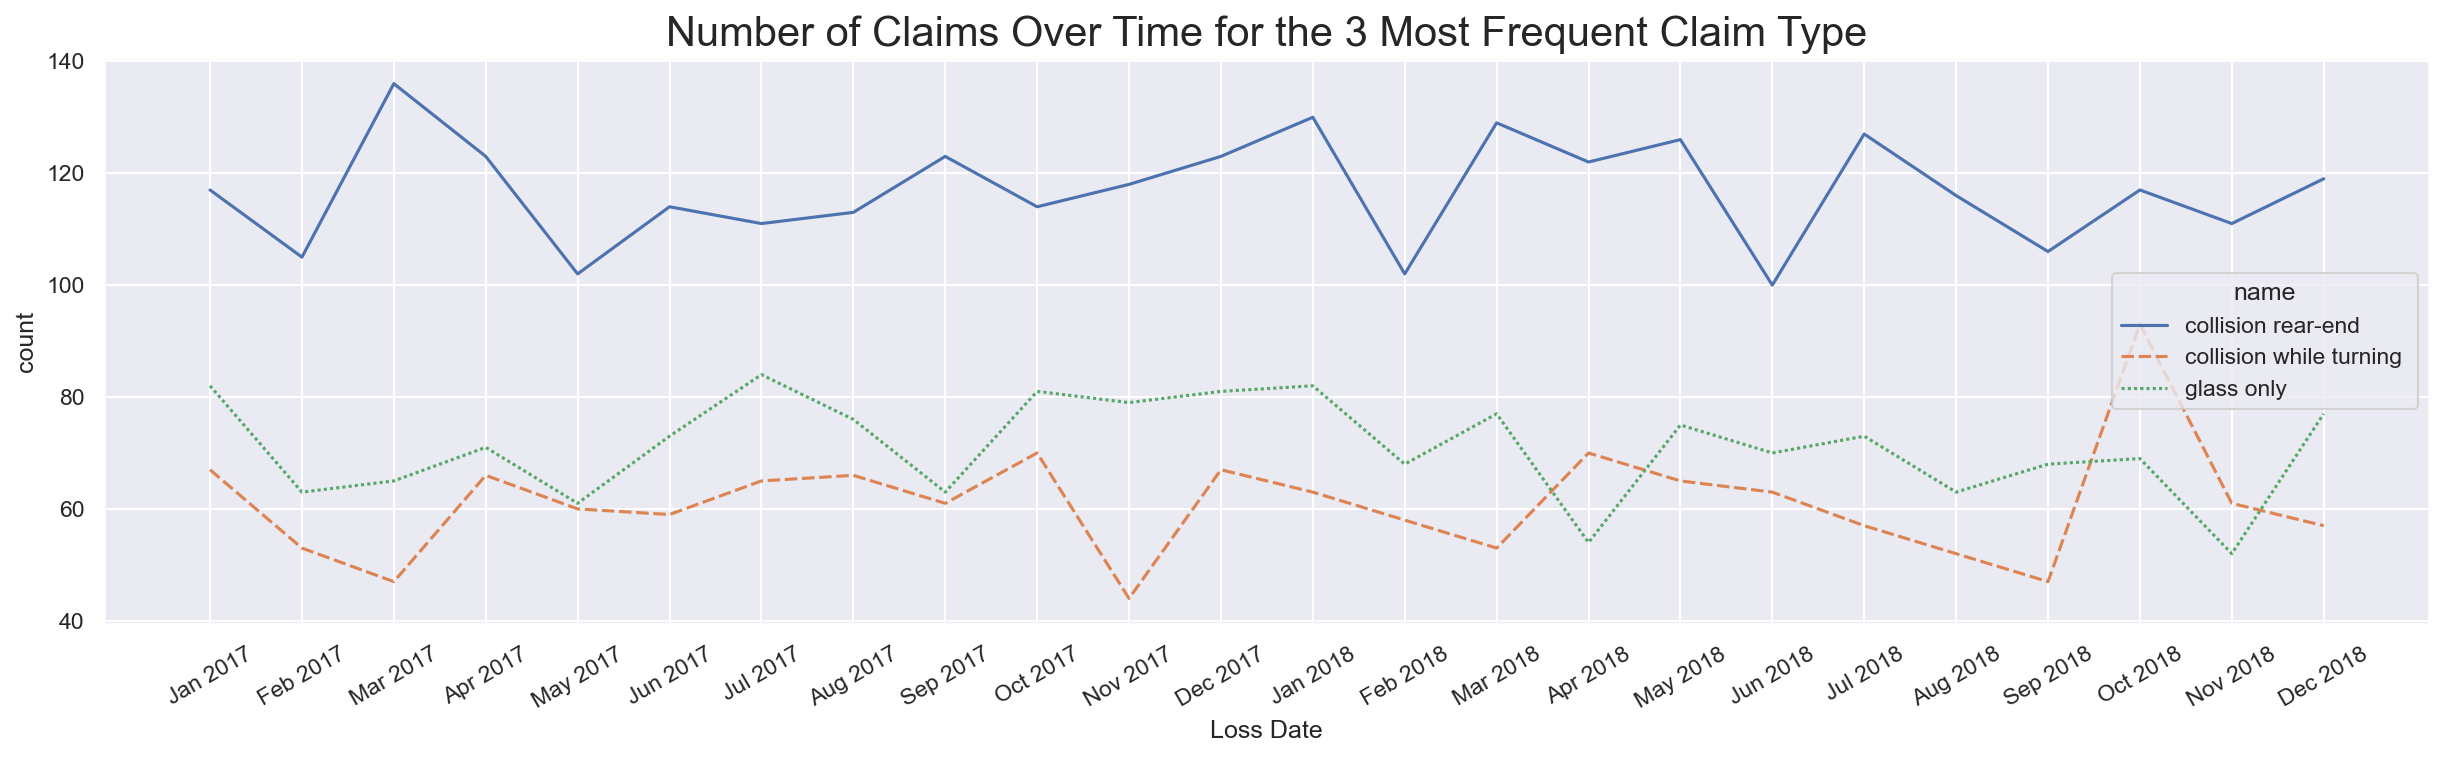

In [42]:
figure(figsize=(20, 5), dpi=150)
ax = sns.lineplot(data=top3ClaimsByDate, x="Loss Date", y="count", hue="name", style="name")
plt.setp(ax.get_xticklabels(), rotation=30)
plt.title("Number of Claims Over Time for the 3 Most Frequent Claim Type", fontsize=20)
plt.show()

## General Trend

In [43]:
claims['lossdatetime'] = claims['lossdate'].apply(pd.to_datetime)

In [44]:
# For all claims 
claimsHour = claims.copy()[['lossdatetime', 'fraud']]
claimsHour['time'] = claimsHour['lossdatetime'].apply(lambda x : x.hour)

# For fraud only 
claimsHourFraud = claimsHour[claimsHour['fraud'] == 1]

#### Plot Number of Claims over Hour in Day 

In [45]:
claimsHourGroup = (claimsHour 
             .groupby('time')
             .agg('count')
             .reset_index()
             .rename(columns = {'fraud': 'count'})
             .sort_values(by='time')
             )

Text(0.5, 1.0, 'Number of Claims over Hours in Day')

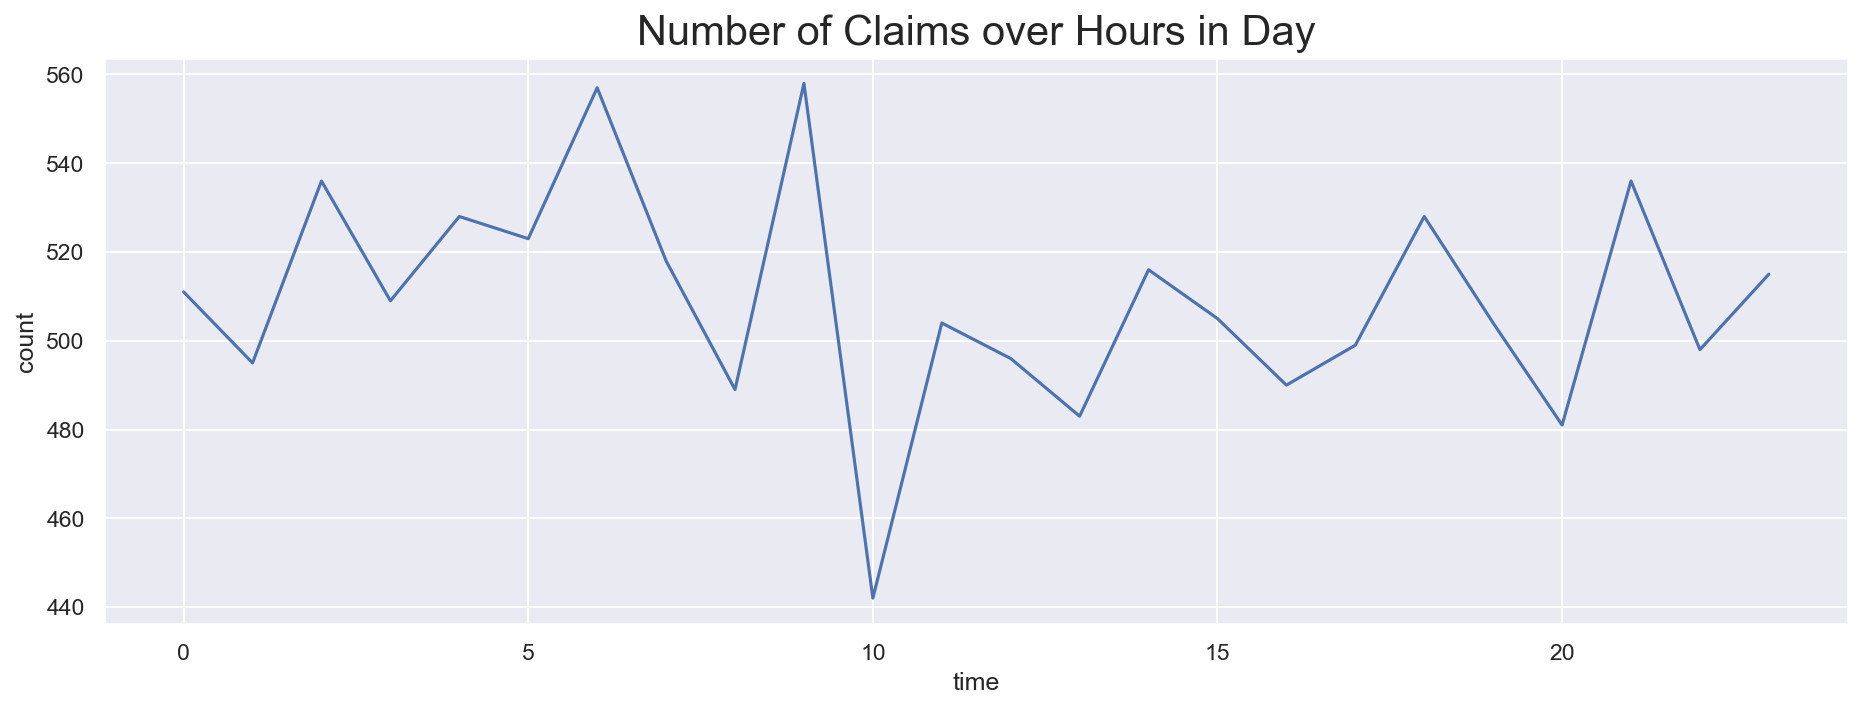

In [46]:
figure(figsize=(15, 5), dpi=150)
ax = sns.lineplot(data=claimsHourGroup, x = 'time', y = 'count')
plt.title("Number of Claims over Hours in Day", fontsize=20)

#### Fraud Claims Plot

In [47]:
claimsHourFraudGroup = (claimsHourFraud 
             .groupby('time')
             .agg('count')
             .reset_index()
             .rename(columns = {'fraud': 'count'})
             .sort_values(by='time')
             )

Text(0.5, 1.0, 'Number of Fraud Claims over Hours in Day')

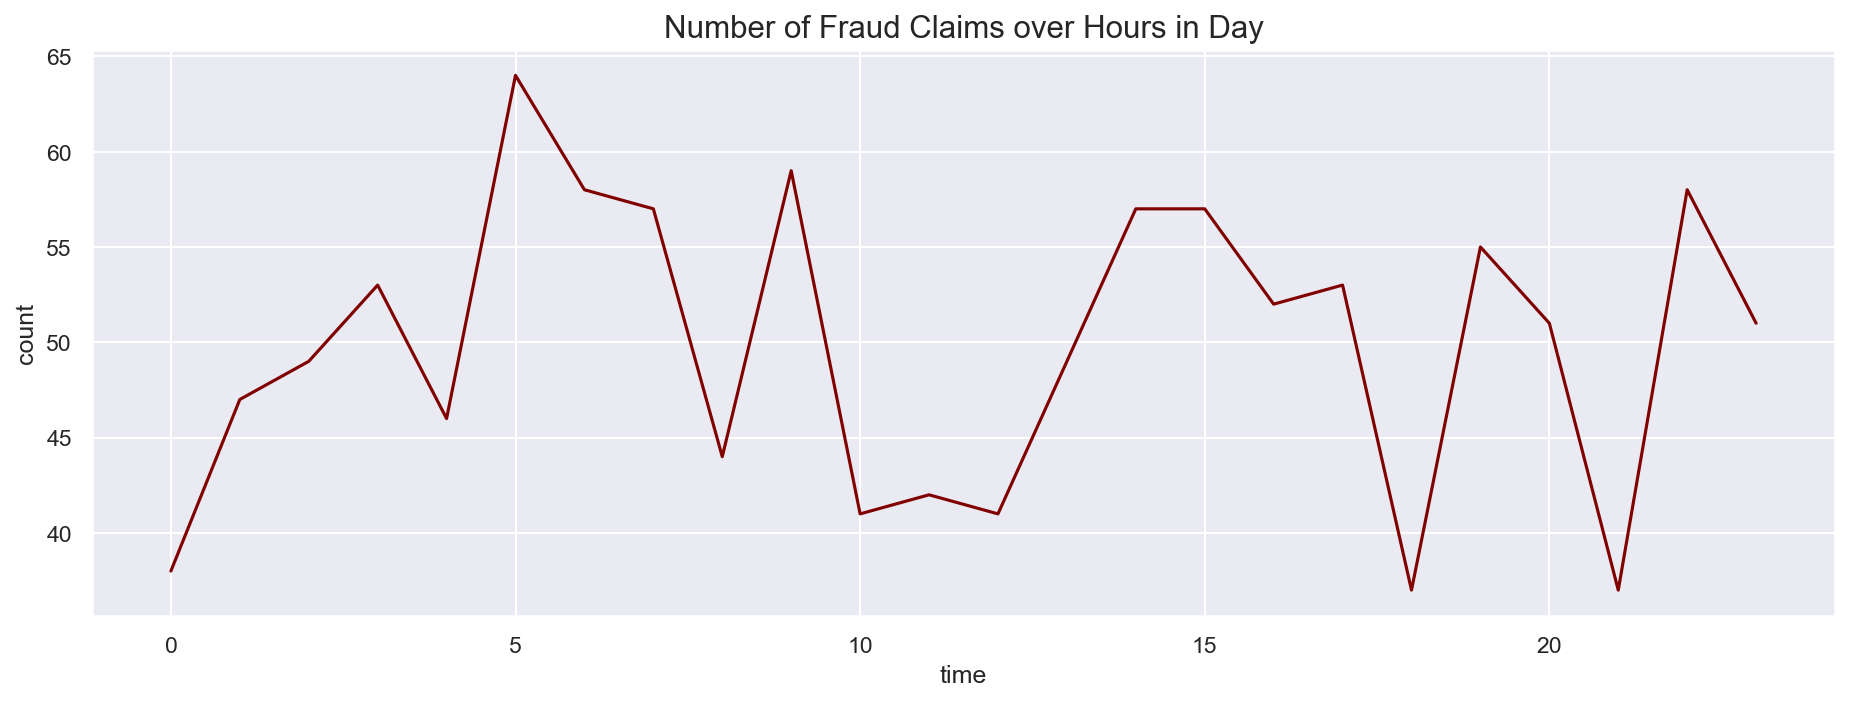

In [49]:
figure(figsize=(15, 5), dpi=150)
ax = sns.lineplot(data=claimsHourFraudGroup, x = 'time', y = 'count', color = 'maroon')
plt.title("Number of Fraud Claims over Hours in Day", fontsize=15)

As we can see, there are certain hours in the day where there were more counts of fraud. However, we can speculate that there are merely more fraudulent claims in certain hour is due to the fact that there were more claims in that hour. Something we can look into is the proportion of fradulent claims over the hour. This can give us more insight to if fradulent claims make up a higher proportion of claims in certain hours. 

In [50]:
claimsHourFraudGroup['total count'] = claimsHourGroup['count']
claimsHourFraudGroup['fraud proportion'] = claimsHourFraudGroup['count'] / claimsHourFraudGroup['total count']

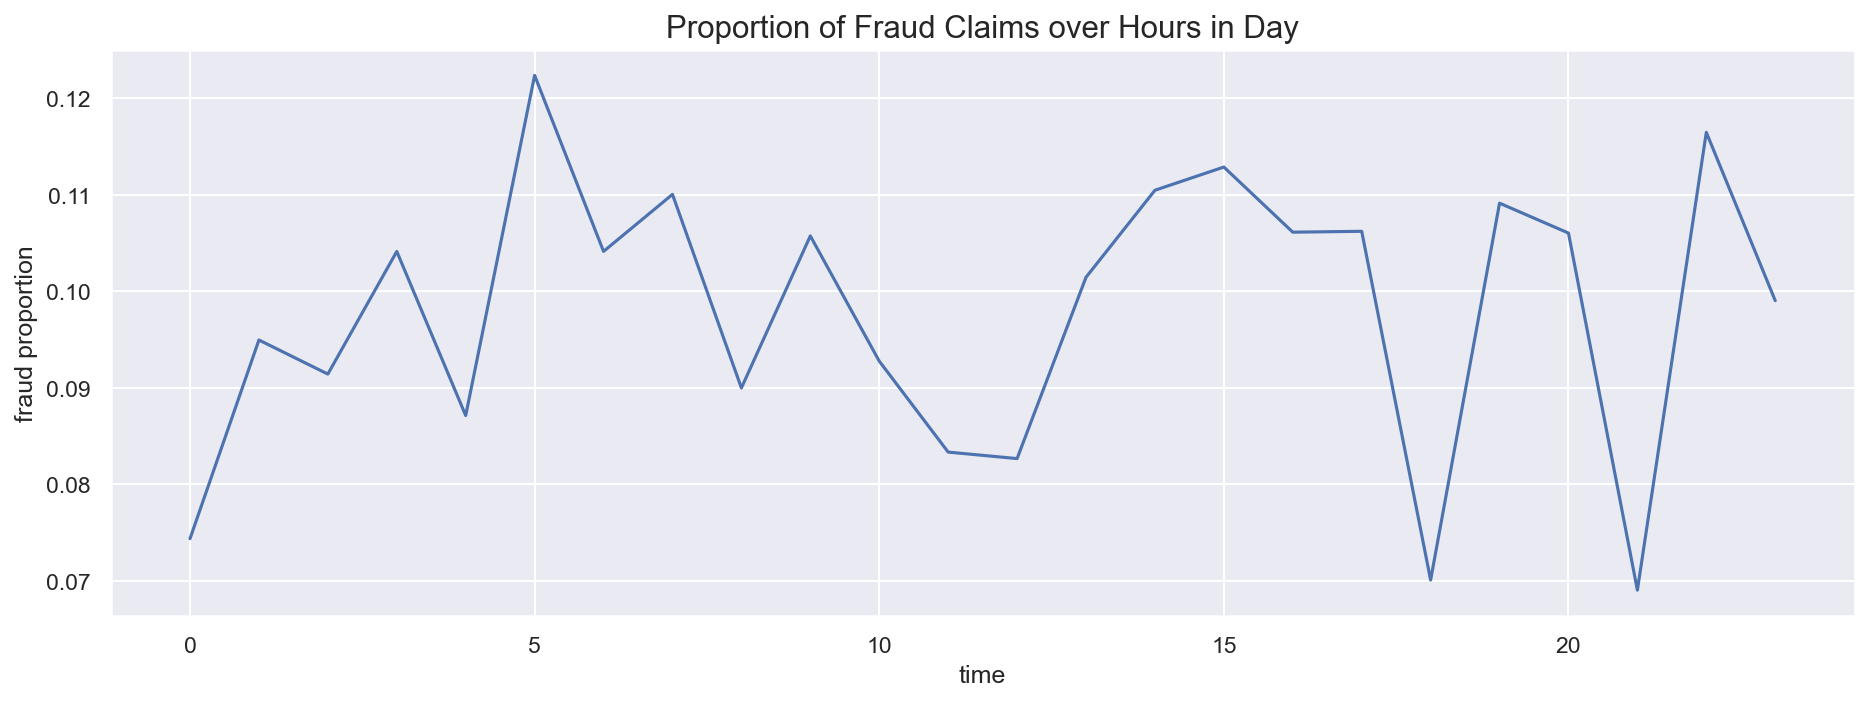

In [51]:
figure(figsize=(15, 5), dpi=150)
plt.title("Proportion of Fraud Claims over Hours in Day", fontsize=15)
ax = sns.lineplot(data=claimsHourFraudGroup, x = 'time', y = 'fraud proportion')

It appears to mirror the previous line plot. 

In [52]:
claimsMonth = claimsHour.copy()
claimsMonth['month'] = claimsMonth['lossdatetime'].apply(lambda x: calendar.month_abbr[x.month])

In [53]:
claimsMonthGroup = (claimsMonth[['fraud', 'month']]
                    .groupby('month')
                    .agg('count')
                    .reset_index()
                    .rename(columns={'fraud':'count'})
                   )

Text(0.5, 1.0, 'Number of Fraud Claims over Months (2017 - 2018)')

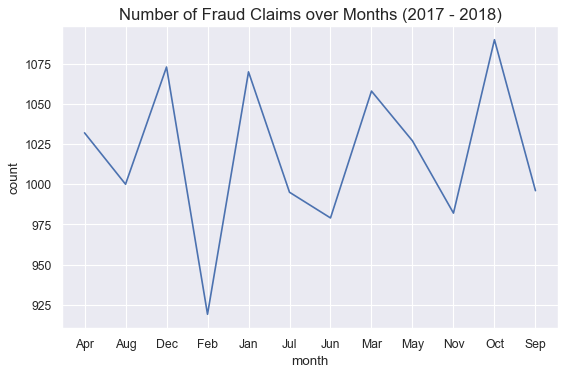

In [64]:
figure(figsize=(8, 5), dpi=80)
sns.lineplot(data=claimsMonthGroup, x = "month", y="count")
plt.title("Number of Fraud Claims over Months (2017 - 2018)", fontsize= 15)

In [65]:
claimsMonthFraud = claimsMonth[claimsMonth['fraud'] == 1]

In [66]:
claimsMonthFraud = (claimsMonthFraud[['fraud', 'month']]
                    .groupby('month')
                    .agg('count')
                    .reset_index()
                    .rename(columns={'fraud':'count'})
                   )

Text(0.5, 1.0, 'Number of Fraud Claims over Months (2017 - 2018)')

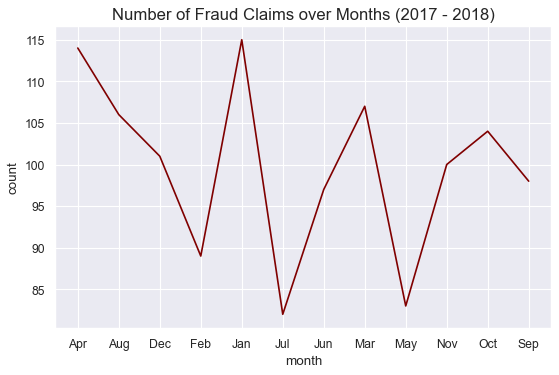

In [67]:
figure(figsize=(8, 5), dpi=80)
sns.lineplot(data=claimsMonthFraud, x = "month", y="count", color = 'maroon')
plt.title("Number of Fraud Claims over Months (2017 - 2018)", fontsize= 15)

#### Months as Customer

In [68]:
claimMonthCustomer = claims[['months_as_customer', 'fraud']]
claimMonthCustomer = claimMonthCustomer.dropna(subset=['months_as_customer']) # drop null values 

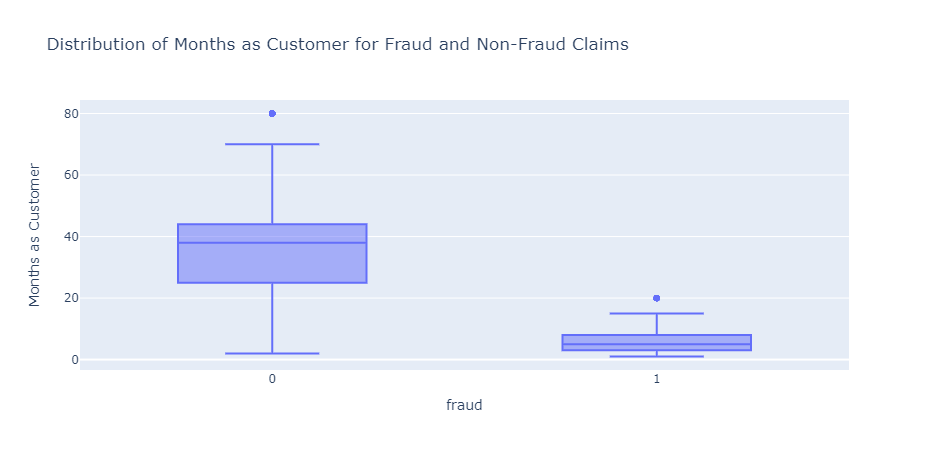

In [69]:
# Plotly for interactivity 
fig = px.box(claimMonthCustomer, x='fraud', 
             y="months_as_customer", 
             title = "Distribution of Months as Customer for Fraud and Non-Fraud Claims")
fig.update_layout(yaxis_title="Months as Customer")
fig.show()

Text(0.5, 1.0, 'Month as Customer vs Fraud')

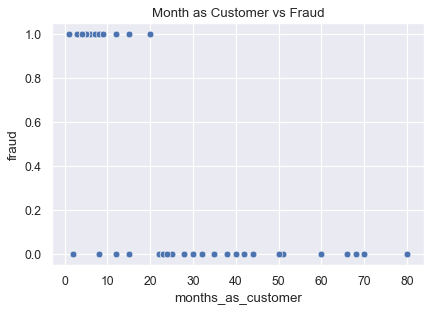

In [70]:
# Would be a great feature to use in our random forest model. 
figure(figsize=(6, 4), dpi=80)
sns.scatterplot(data=claimMonthCustomer, 
                x='months_as_customer', 
                y='fraud',
               ).set_title("Month as Customer vs Fraud")

In [71]:
claimMonthCustomer.corr()

months_as_customer     fraud
months_as_customer            1.000000 -0.517384
fraud                        -0.517384  1.000000

#### Interpretation
From the boxplot above, we can see a distinction in in Months as Customer vs whether or not a claim is fraudulent. The Months as customer for all customers who filed fraudulent claims are lower than the 25th percentile of non-fraudulent claims. 

The median months as customer of non-fraudulent claims is 38 months whereas the median for that of fraudulent claims is 5 months. **Months as Customer** would be a great feature to use in a predictive model. 

## Collisions

In [72]:
# Filter for collisions only 
re_collision = r'collision'
collisionClaims = claims[claims['name'].apply(lambda x: len(re.findall(re_collision, x)) > 0 )]

In [73]:
print("There are {} Collissions".format(collisionClaims.shape[0]))
print("{} of which were frauds.".format(collisionClaims['fraud'].value_counts()[1.0]))

There are 8876 Collissions
863 of which were frauds.


Now, let's look closer at each type of Collisions and how many of them were fradulent v.s not fraudulent.

### All Collisions

Text(0.5, 1.0, 'Top 5 Number of Claims for Type of Collision')

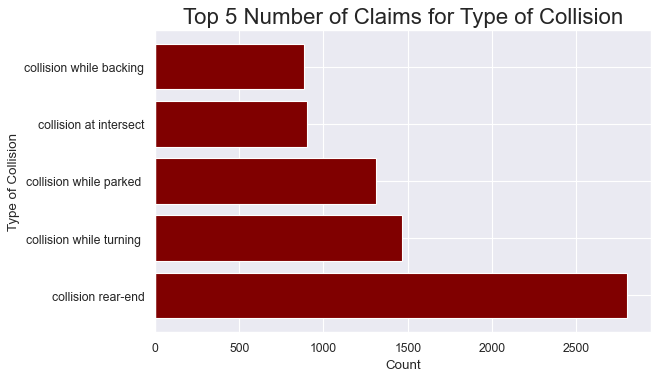

In [74]:
figure(figsize=(8, 5), dpi=80)
collisionClaimsCount = collisionClaims['name'].value_counts()
collisionClaimsCount = collisionClaimsCount.reset_index()[:5]
plt.barh(y = collisionClaimsCount['index'], width=collisionClaimsCount['name'], color = "maroon")
plt.xlabel("Count")
plt.ylabel("Type of Collision")
plt.title("Top 5 Number of Claims for Type of Collision", fontsize=20)

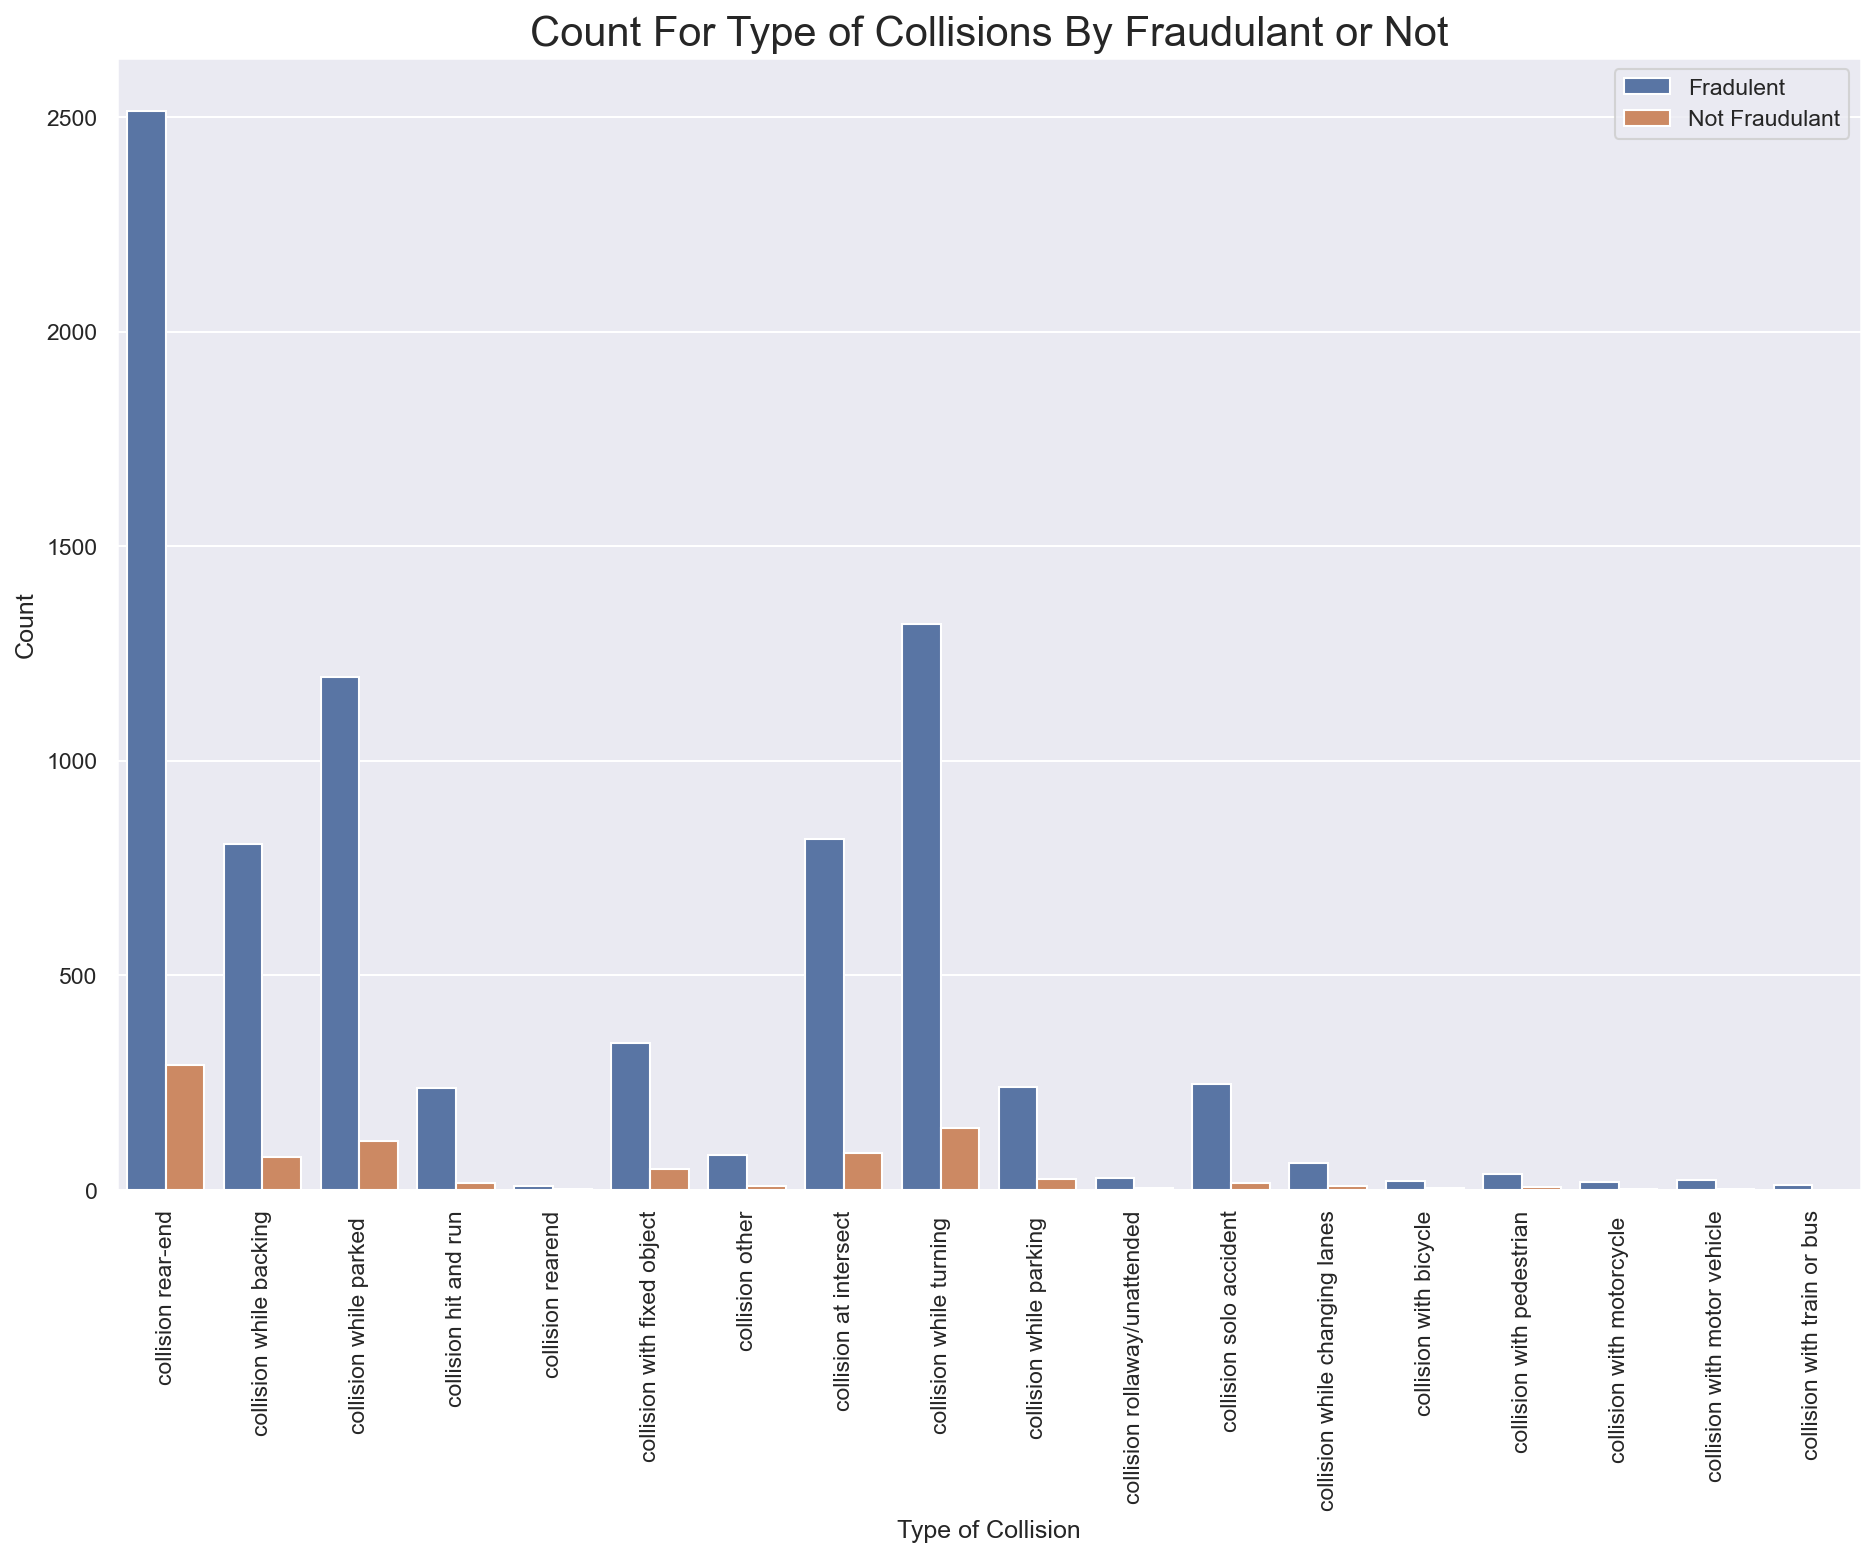

In [75]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x = 'name', hue="fraud", data=collisionClaims)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Count For Type of Collisions By Fraudulant or Not", fontsize = 20)
plt.xlabel("Type of Collision")
plt.ylabel("Count")
plt.legend(loc='upper right', labels=['Fradulent', 'Not Fraudulant'])
plt.show(ax)

### Fraudulent Collisions 

In [76]:
collisionFraudProp = (collisionClaims[['name', 'fraud']]
                      .groupby('name')
                      .agg(lambda x: round(np.mean(x), 2))
                      .reset_index()
                      .rename(columns = {"fraud":"fraud proportion"})
)

Text(0.5, 0, 'Fraud Proportion')

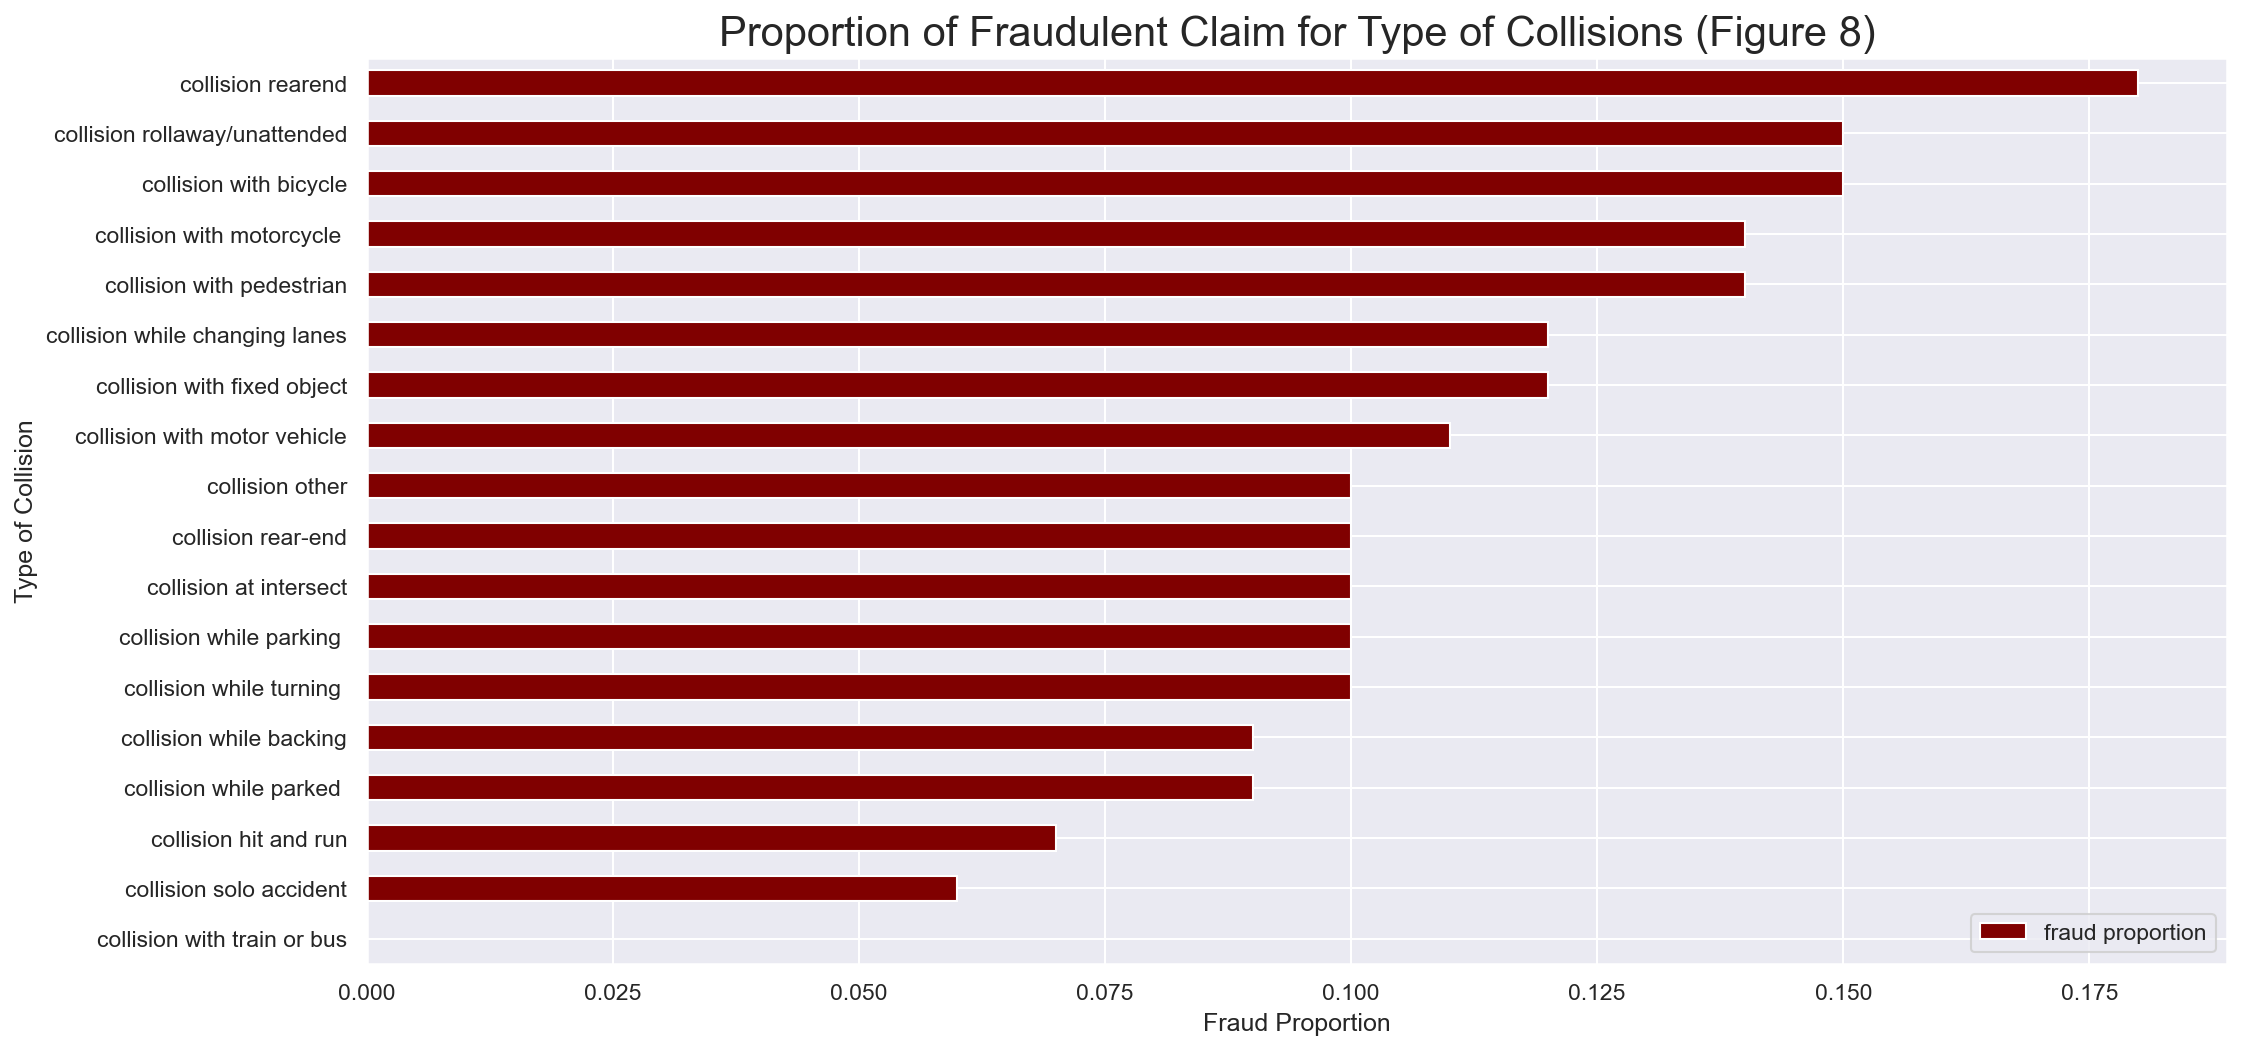

In [77]:
collisionFraudProp.sort_values('fraud proportion', inplace=True)
collisionFraudProp.plot.barh(x='name', color='maroon')
plt.legend(loc='lower right')
plt.title("Proportion of Fraudulent Claim for Type of Collisions (Figure 8)", fontsize = 20)
plt.ylabel("Type of Collision")
plt.xlabel("Fraud Proportion")

#### Interpretation
* `Collision Rollaway/Unattended` and `Collision with Bicycle` did not make up a large proportion of collision claims (`Figure 1`) but has the highest proportion of fradulent claims (`Figure 3`) at 15% for both.


* `Collision with Motorcycle` and `Collision with Pedestrian` also did not make up a large proportion of collision claims but has the second highest proportion of fradulent claims at 14% for both. 

It appears that less frequent type of collisions in our dataset are showing a higher proportion of fradulent activities. 

* The most frequent types of Collisions (i.e `Collision Rearend`, `Collision at Intersection`, `Collision while Parking`) have around 10% of fraudulent claim. 

* 0% of collision with train or bus claims were found to be fraudulent. This is likely because collisions with a train or bus is often severe, so I hypothesize that someone looking to do insurance fraud would less likely to get in some kind of collision with train or bus simply for insurance fraud.


### Fraud Proportion By Car Type 

No handles with labels found to put in legend.


Text(0.5, 0, 'Fraud Proportion')

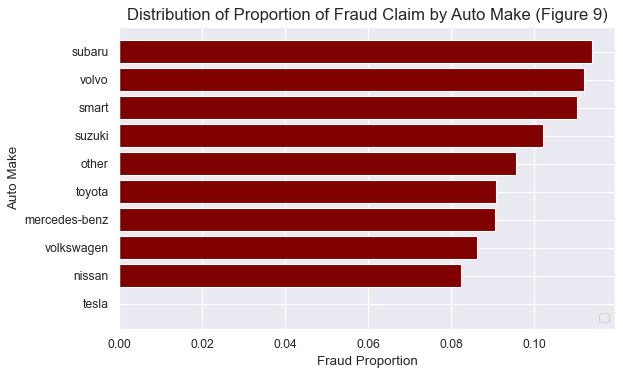

In [78]:
collisionByCar = (collisionClaims[['auto_make', 'fraud']]
                  .groupby('auto_make')
                  .agg('mean')
                  .rename(columns = {"fraud":"fraud proportion"})
                  .reset_index()
                 )
collisionByCar.sort_values('fraud proportion', inplace=True)

figure(figsize=(8, 5), dpi=80)
plt.barh(y = collisionByCar['auto_make'], width=collisionByCar['fraud proportion'], color = "maroon")
plt.legend(loc='lower right')
plt.title("Distribution of Proportion of Fraud Claim by Auto Make (Figure 9)", fontsize = 15)
plt.ylabel("Auto Make")
plt.xlabel("Fraud Proportion")

### Missing Values 

It appears that missing values for `auto_make` appears in collisions as well as non-car related claims. There are,however, more non-car related claims that do not appear in here. My decision will be to replace the nulls as `other`.

In [79]:
claims[claims['auto_make'].isnull()]['name'].unique()

array(['collision while parked ', 'collision rear-end', 'glass only ',
       'collision while turning ', 'vandalism', 'collision at intersect',
       'collision with fixed object', 'animal'], dtype=object)

## Others 

### Incident Severity and Fraud Claims

In [80]:
claims[['incident_severity', 'fraud']].fillna("Other").groupby('incident_severity').agg('mean')

fraud
incident_severity          
Major Damage       0.093486
Minor Damage       0.098720
Total Loss         0.100728
Trivial Damage     0.098720

There appears to be around the same proportion of fraud among all type of incident severity, all around 9-10%. However, `Total Loss` has the highest proportion of fradulent claim. 

### Bodily Injuries and Fraud 

Text(0, 0.5, 'Fraud Proportion')

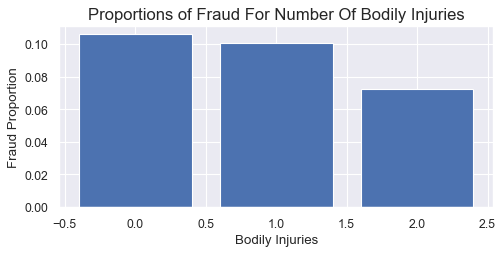

In [81]:
claimsInjury = (claims[['bodily_injuries', 'fraud']]
                .dropna()
                .groupby('bodily_injuries')
                .agg('mean')
                .reset_index()
               )
plt.figure(figsize=(7,3), dpi = 80)
plt.bar(x=claimsInjury['bodily_injuries'], height=claimsInjury['fraud'])
plt.title("Proportions of Fraud For Number Of Bodily Injuries", fontsize=15)
plt.xlabel("Bodily Injuries")
plt.ylabel("Fraud Proportion")

## Claims with Highest Fraud Proportion

Text(0.5, 1.0, 'Top 7 Claims with the Highest Proportion of Fraud')

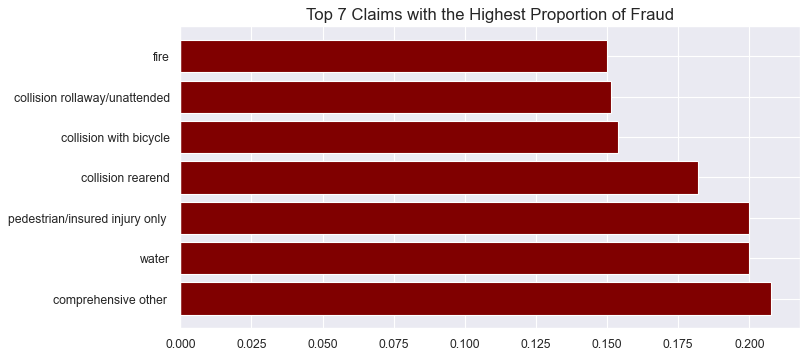

In [82]:
top_7_fraud_claim = (claims.groupby('name')
                     .agg('mean')[['fraud']]
                     .rename(columns={'fraud':'fraud proportion'})
                     .sort_values('fraud proportion', ascending = False)
                     .reset_index()
                     .head(7)
                    )
figure(figsize=(10, 5), dpi=80)
plt.barh(y = top_7_fraud_claim['name'], width=top_7_fraud_claim['fraud proportion'], color = "maroon")
plt.title("Top 7 Claims with the Highest Proportion of Fraud",fontsize=15)

### Gender and Fraud Proportion 

Text(0, 0.5, 'Sex')

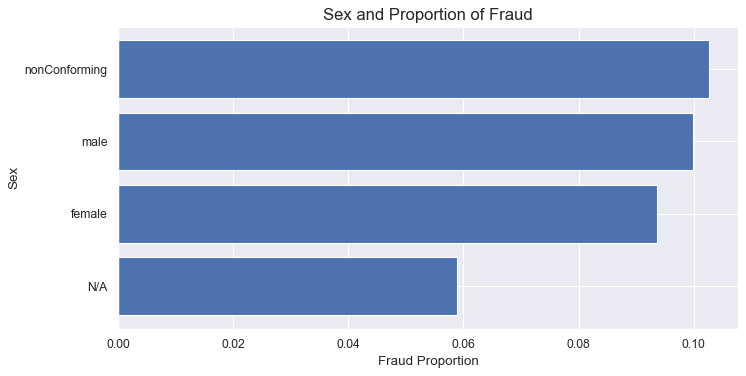

In [83]:
claimsSex = (claims[['insured_sex', 'fraud']]
 .fillna('N/A')
 .groupby('insured_sex')
 .agg('mean')
 .reset_index()
)

figure(figsize=(10, 5), dpi=80)
plt.barh(y = claimsSex['insured_sex'], width=claimsSex['fraud'])
plt.title("Sex and Proportion of Fraud",fontsize=15)
plt.xlabel("Fraud Proportion")
plt.ylabel("Sex")

### Insured Occupation

Text(0, 0.5, 'Insured Occupation')

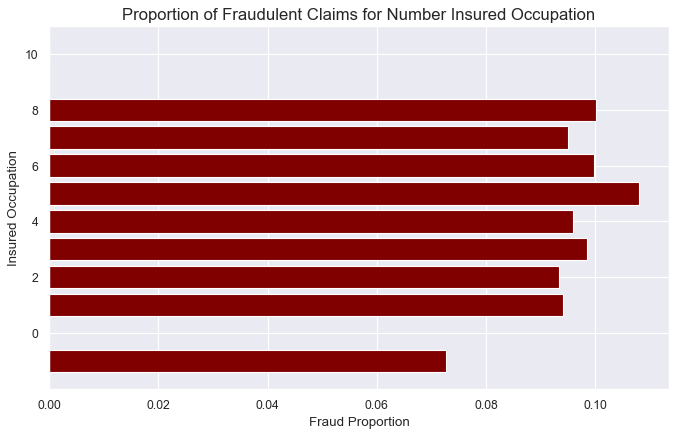

In [84]:
claimsInsured = (claims[['insured_occupation', 'fraud']]
                 .fillna(-1).groupby('insured_occupation')
                 .agg('mean').sort_values("fraud")
                 .reset_index()
)

figure(figsize=(10, 6), dpi=80)
plt.barh(y = claimsInsured['insured_occupation'], width=claimsInsured['fraud'], color="maroon")
plt.title("Proportion of Fraudulent Claims for Number Insured Occupation", fontsize=15)
plt.xlabel("Fraud Proportion")
plt.ylabel("Insured Occupation")

Text(0, 0.5, 'State')

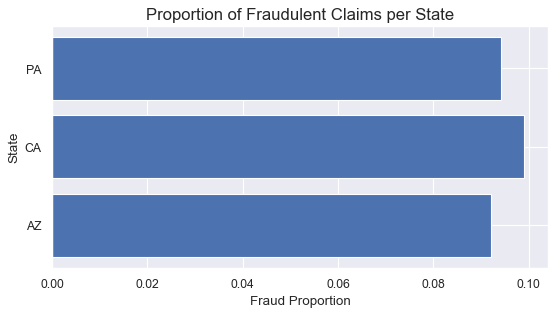

In [107]:
claimsFraudProp = (claims[['insured_state', 'fraud']]
                   .groupby('insured_state')
                   .agg('mean')
                   .reset_index()
                  )

figure(figsize=(8, 4), dpi=80)
plt.barh(y = claimsFraudProp['insured_state'], width=claimsFraudProp['fraud'])
plt.title("Proportion of Fraudulent Claims per State", fontsize=15)
plt.xlabel("Fraud Proportion")
plt.ylabel("State")

# Processing and Modeling

## Feature Selection
I will be using the following features in the model: 

1. `name` - It appears that there are far higher proportions of fraudulent claims for certain types of claim. 

    Encoding Approach : Hot-One Encoding 


2. `incident_severity`- For incident severity, it appears that Total Loss has the highest proportion of fraudulent claim. 
    
    Encoding Approach - Ordinal Encoding. 
    
    
3. `auto_make` - Although not all claims are collisions, during my EDA I see that certain make of cars have a noticebly higher proportion of fradulent claims (SUBURU) while others (TESLA 0% fraud) have lower proportions. 


4. `months_as_customer` - Out of everything, I believe this was one of the most strongest feature to use. From the boxplot (Figure 5), we can see that the distribution of months as customer different significantly between fraudulent and non-fraudulent. 

5. `month` - Some months have a lot of frauds, whereas some months have very little. 


6. `hour` - There are spikes in fraud claims in certain hours. So I think this will be a great feature

#### Import Additional Modules 

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import sklearn as sk
from imblearn.ensemble import BalancedRandomForestClassifier 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import KFold

# Util model I created
import data_processing_utils as dp
import utils 

#### Loading Our Data

In [16]:
fullClaims = pd.read_csv("Claims.csv")

#### Building our Pipeline Model

In [17]:
# Features we are selecting 
features = ['name', 'fraud','month', 'incident_severity', 'auto_make', "months_as_customer", "hour", "insured_occupation"]

# all possible auto_make group 
auto_group = dp.clean_auto_make(fullClaims)[['auto_make', 'fraud']].groupby('auto_make').agg('mean')
automake_fraud_dict = dict(zip(auto_group.index, auto_group['fraud']))

# all expected columns from 'name' for hot-one-encodig
required_cols = dp.clean_name(fullClaims)['name'].dropna().unique()
required_cols = np.append(required_cols, 'other')

# what to fill for null entries. 
null_entry_mapping = {'insured_occupation' : 0, 'incident_severity': 'NA', 'name' : 'other'}

In [18]:
pipeline_model = [
    # Data Cleaning 
    (dp.remove_duplicates_and_full_nulls, None, None), 
    (dp.extract_month_hour, None, {'lossdate_col' : 'lossdate'}),
    (dp.select_cols, None, {'columns': features}),
    (dp.fill_drop_null_entries, None,{'col_mappings' : null_entry_mapping}),
    (dp.clean_name, None, None),
    (dp.clean_auto_make, None, None),
    # Encodings
    (dp.auto_make_target_encoding, None, {'col_name':'auto_make', 'encodings': automake_fraud_dict}),
    (dp.damage_ordinal_encoding, None, None),
    (dp.ohe_name, None, {'target':'name', 'expected_names' : required_cols})
]

#### Split Train and Test Sets and Process Data 

In [83]:
# Split to X (features) and y (prediction)
X = fullClaims.drop(columns=['fraud'])
y = fullClaims['fraud']

# Ensures even splitting of fraudulent activities vs not among both test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

train_data = X_train.join(y_train)
test_data = X_test.join(y_test)

# Process train and test data 
X_train, Y_train = dp.process_data_gm(train_data, pipeline_model, 'fraud')
X_test, Y_test = dp.process_data_gm(test_data, pipeline_model, 'fraud')

### Class Imbalance Solution

In [82]:
np.average(Y_train)

0.09896567936060179

The proportion of fradulent claim only makes up 9.8% of our testing data. Both **recall** and **precision** suffer if a dataset is unbalanced. Two solutions to class Imbalance is **oversampling** and **undersampling**. 

What is oversampling or undersampling? 

**Oversampling** : duplicate or create new synthetic examples in the minority class

**UnderSampling** : delete or merge examples in the majority class. 

I decided to go with oversampling! Why? Undersampling deletes what could be useful data. With oversampling, we will not be losing any information. 

**Note:** Why do we oversample after splitting? The reason why do not want to oversample and then split is because some of data oversampled data will leak into the test set. This means that those data points have already been seen by the model, so it will accurately predict those. However, this is giving a false sense that the model is performing better than it actually does. 

### Cross-Validation for Oversampling

In [20]:
trainCV = X_train.join(y_train)
X_CV_train, y_CV_train = dp.process_data_gm(trainCV, pipeline_model, 'fraud')

### Recalls or Precisions?
**Business Question: Should we prioritize precision or recall?**

If we work to drive precision to 100%, then while all the fradulent claims we marked as fraud are indeed fraud, many other fradulent are slipping through which makes the company lose money. However, if we focus on driving recall to 100%, we might misclasify customers with non-fradulent claims as fradulent; we might make them angry! I would suggest to try and drive the 100% recall up so that when a claim is marked as fradulent, the system can flag it and a person within the company can look at the claim to validate. However, the downside to this is if we're flagging hundreds of thousandas of claims as fradulent (still catching all fradulent), it might not be feasible to look into all of them.

I will be creating a recall driven and a precision driven model. 

### Cross Validation - Oversampling Percentage

In [21]:
model = BalancedRandomForestClassifier(n_estimators = 100, random_state = 0)
percentages = np.arange(0.5, 1, 0.05)

In [22]:
recalls = {}
for p in percentages: 
    recalls[p] = utils.compute_CV_recall(model, sk.metrics.recall_score, X_CV_train, y_CV_train, p)

In [23]:
precisions = {}
for p in percentages: 
    precisions[p] = utils.compute_CV_recall(model, sk.metrics.precision_score, X_CV_train, y_CV_train, p)

In [24]:
recalls

{0.5: 0.9148902631018753,
 0.55: 0.892698487576091,
 0.6000000000000001: 0.8770192695565213,
 0.6500000000000001: 0.8710550516799775,
 0.7000000000000002: 0.8642978656104082,
 0.7500000000000002: 0.8512102960192129,
 0.8000000000000003: 0.845346091645667,
 0.8500000000000003: 0.8358329308271809,
 0.9000000000000004: 0.8285817494281522,
 0.9500000000000004: 0.8192642753882684}

In [25]:
precisions

{0.5: 0.6613017037982305,
 0.55: 0.6815669170830687,
 0.6000000000000001: 0.718900934297684,
 0.6500000000000001: 0.7198973447939069,
 0.7000000000000002: 0.7451228294581824,
 0.7500000000000002: 0.7706273954976595,
 0.8000000000000003: 0.7762091750264615,
 0.8500000000000003: 0.7946195731010837,
 0.9000000000000004: 0.8038307867110353,
 0.9500000000000004: 0.8100429167522831}

In [32]:
print("Recall driven:", max(recalls, key = recalls.get), "-", max(recalls.values()))
print("Precision driven", max(precisions, key=precisions.get), "-", max(precisions.values()))

Recall driven: 0.5 - 0.9148902631018753
Precision driven 0.9500000000000004 - 0.8100429167522831


# Build Random Forest Classifier

### Recall driven model 

In [34]:
oversample_prop_recall =  max(recalls, key=recalls.get)
oversample_recall = RandomOverSampler(sampling_strategy = oversample_prop_recall)
X_train_recall, Y_train_recall = oversample_recall.fit_resample(X_train, Y_train)

In [53]:
model_recall = BalancedRandomForestClassifier(n_estimators = 100, random_state = 5)
model_recall.fit(X_train_recall, Y_train_recall)
y_pred_recall = model_recall.predict(X_test)

### Precision driven model 

In [36]:
oversample_prop_precision =  max(precisions, key=precisions.get)
oversample_precision= RandomOverSampler(sampling_strategy = oversample_prop_precision)
X_train_precision, Y_train_precision = oversample_precision.fit_resample(X_train, Y_train)

In [47]:
model_precision = BalancedRandomForestClassifier(n_estimators = 100, random_state = 5)
model_precision.fit(X_train_precision, Y_train_precision)
y_pred_precision = model_precision.predict(X_test)

# Model Evaluation

1. **Precision - What percent of your predictions were correct?** 

    TP/(TP+FP)

2. **Recall - What percent of the positive cases did you catch?** 

    TP/(TP+FN)

3. **F1 - What percent of positive predictions were correct?**

    2 * (Recall * Precision)/ (Recall + Precision)

4. **AUC - Measure the ability of a classifier to distinguish between classes** 

    The closer the AUC is to 1, the better the classifier is at distinguishing between class. 

    0.5 means it has no classification abilities. 

## Recall Driven Model Evaluation

Training Accuracy:  0.9952169753891643
Testing Accuracy:  0.9482900136798905
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      3305
         1.0       0.67      0.90      0.77       350

    accuracy                           0.95      3655
   macro avg       0.83      0.93      0.87      3655
weighted avg       0.96      0.95      0.95      3655



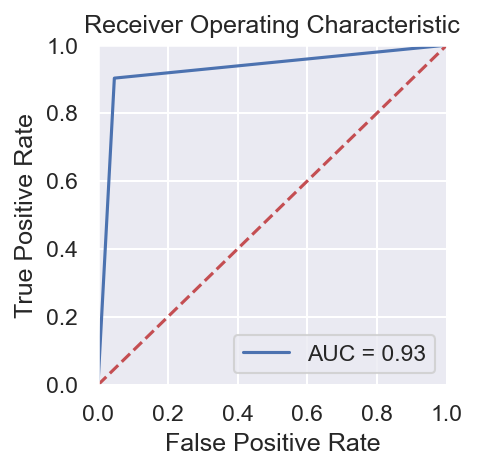

In [54]:
utils.display_report(model_recall, X_train_recall, Y_train_recall, X_test, Y_test)
utils.display_ROC(Y_test, y_pred_recall)

## Precision Driven Model Evaluation

Training Accuracy:  0.99993310141825
Testing Accuracy:  0.9690834473324214
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      3305
         1.0       0.84      0.83      0.84       350

    accuracy                           0.97      3655
   macro avg       0.91      0.91      0.91      3655
weighted avg       0.97      0.97      0.97      3655



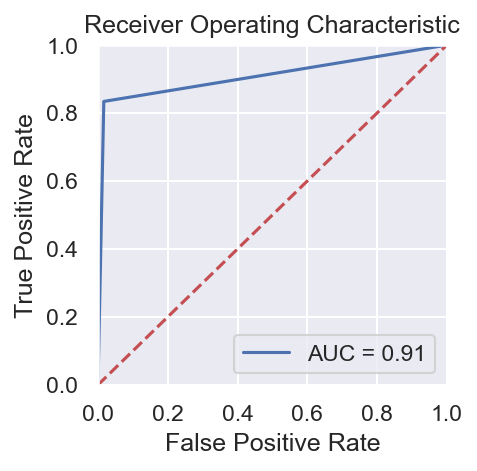

In [48]:
utils.display_report(model_precision, X_train_precision, Y_train_precision, X_test, Y_test)
utils.display_ROC(Y_test, y_pred_precision)

## Feature Importance 

Text(0.5, 0, 'Relative Importance')

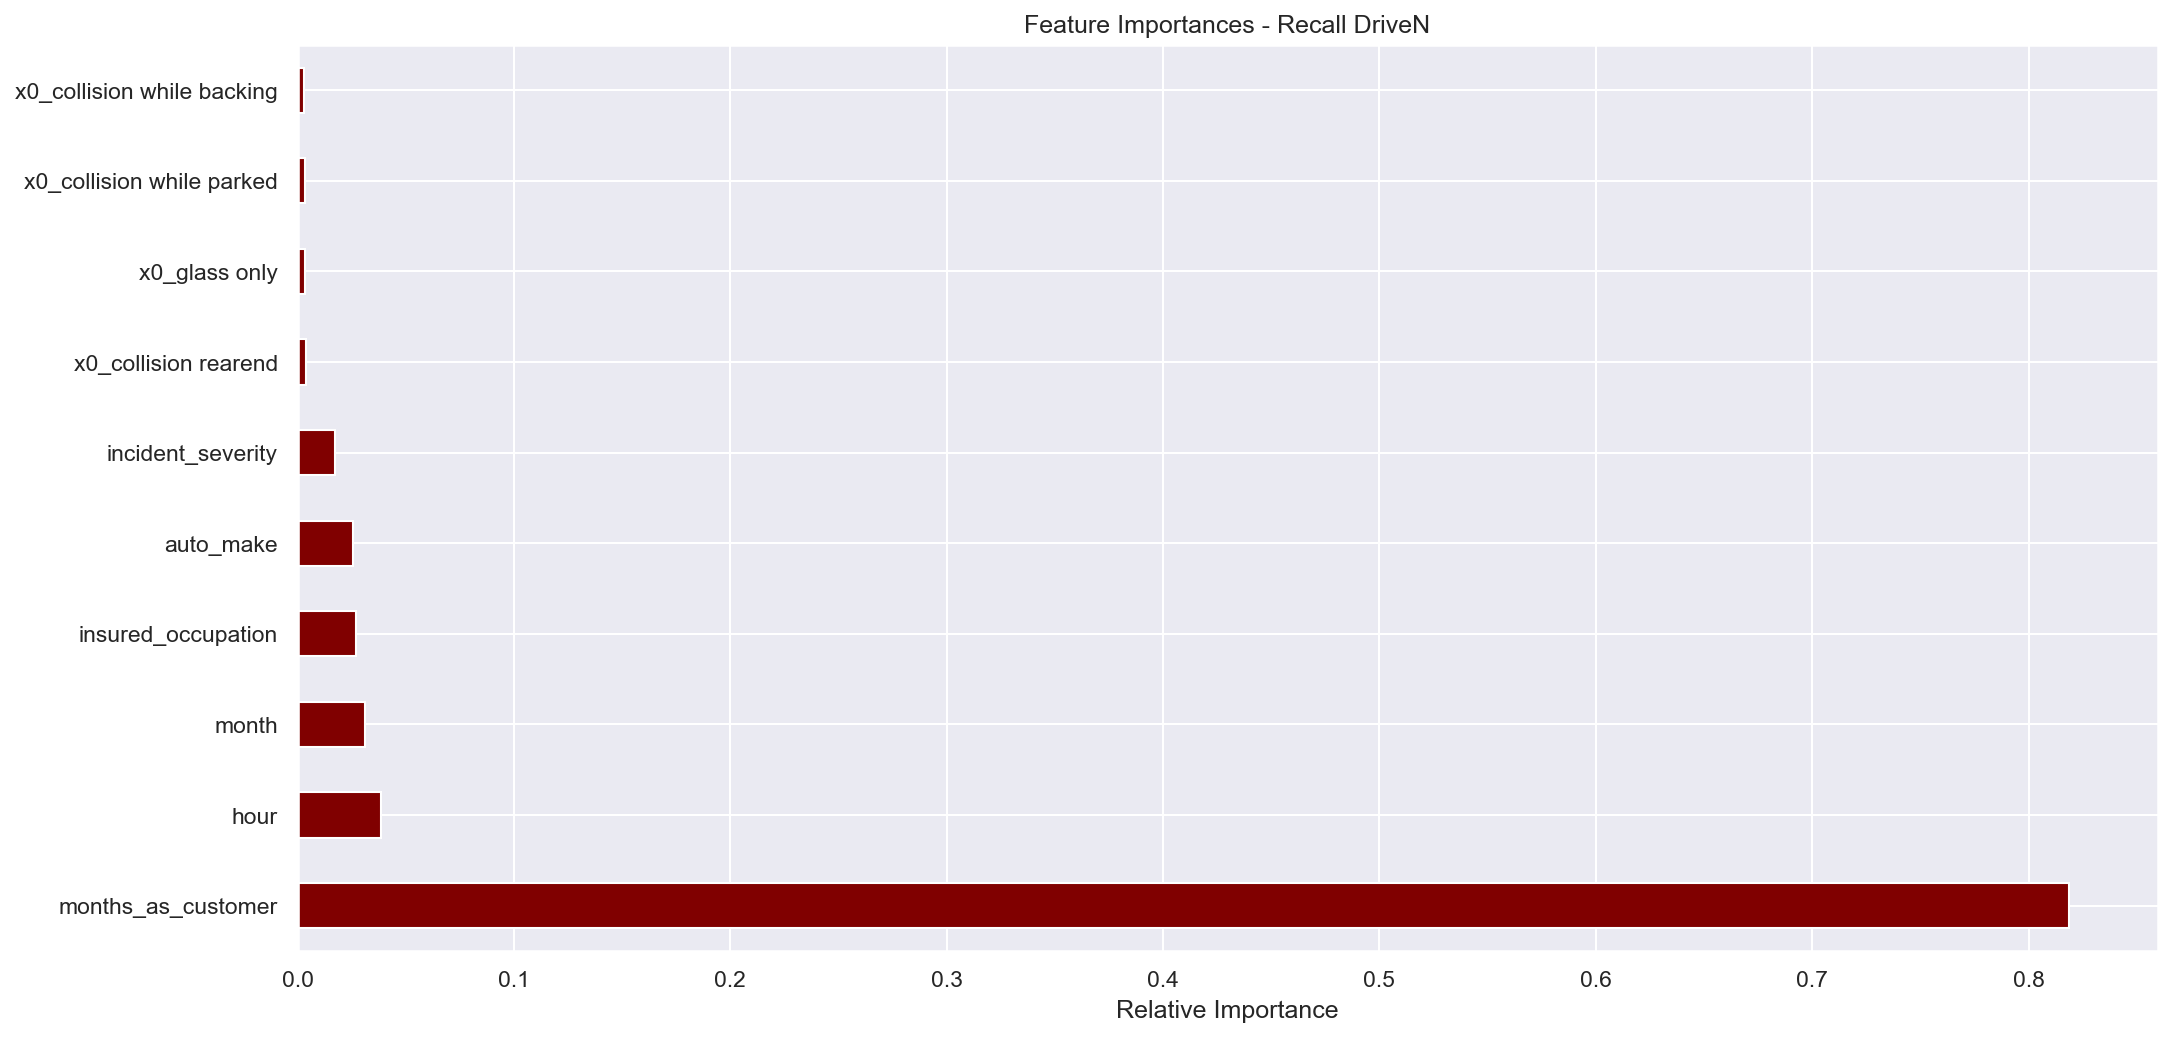

In [45]:
features = np.array(X_train_recall.columns)
plt.title('Feature Importances - Recall DriveN')
feat_importances = pd.Series(model_recall.feature_importances_, index=features)
feat_importances.nlargest(10).plot(kind='barh', color = 'maroon')
plt.xlabel('Relative Importance')

Text(0.5, 0, 'Relative Importance')

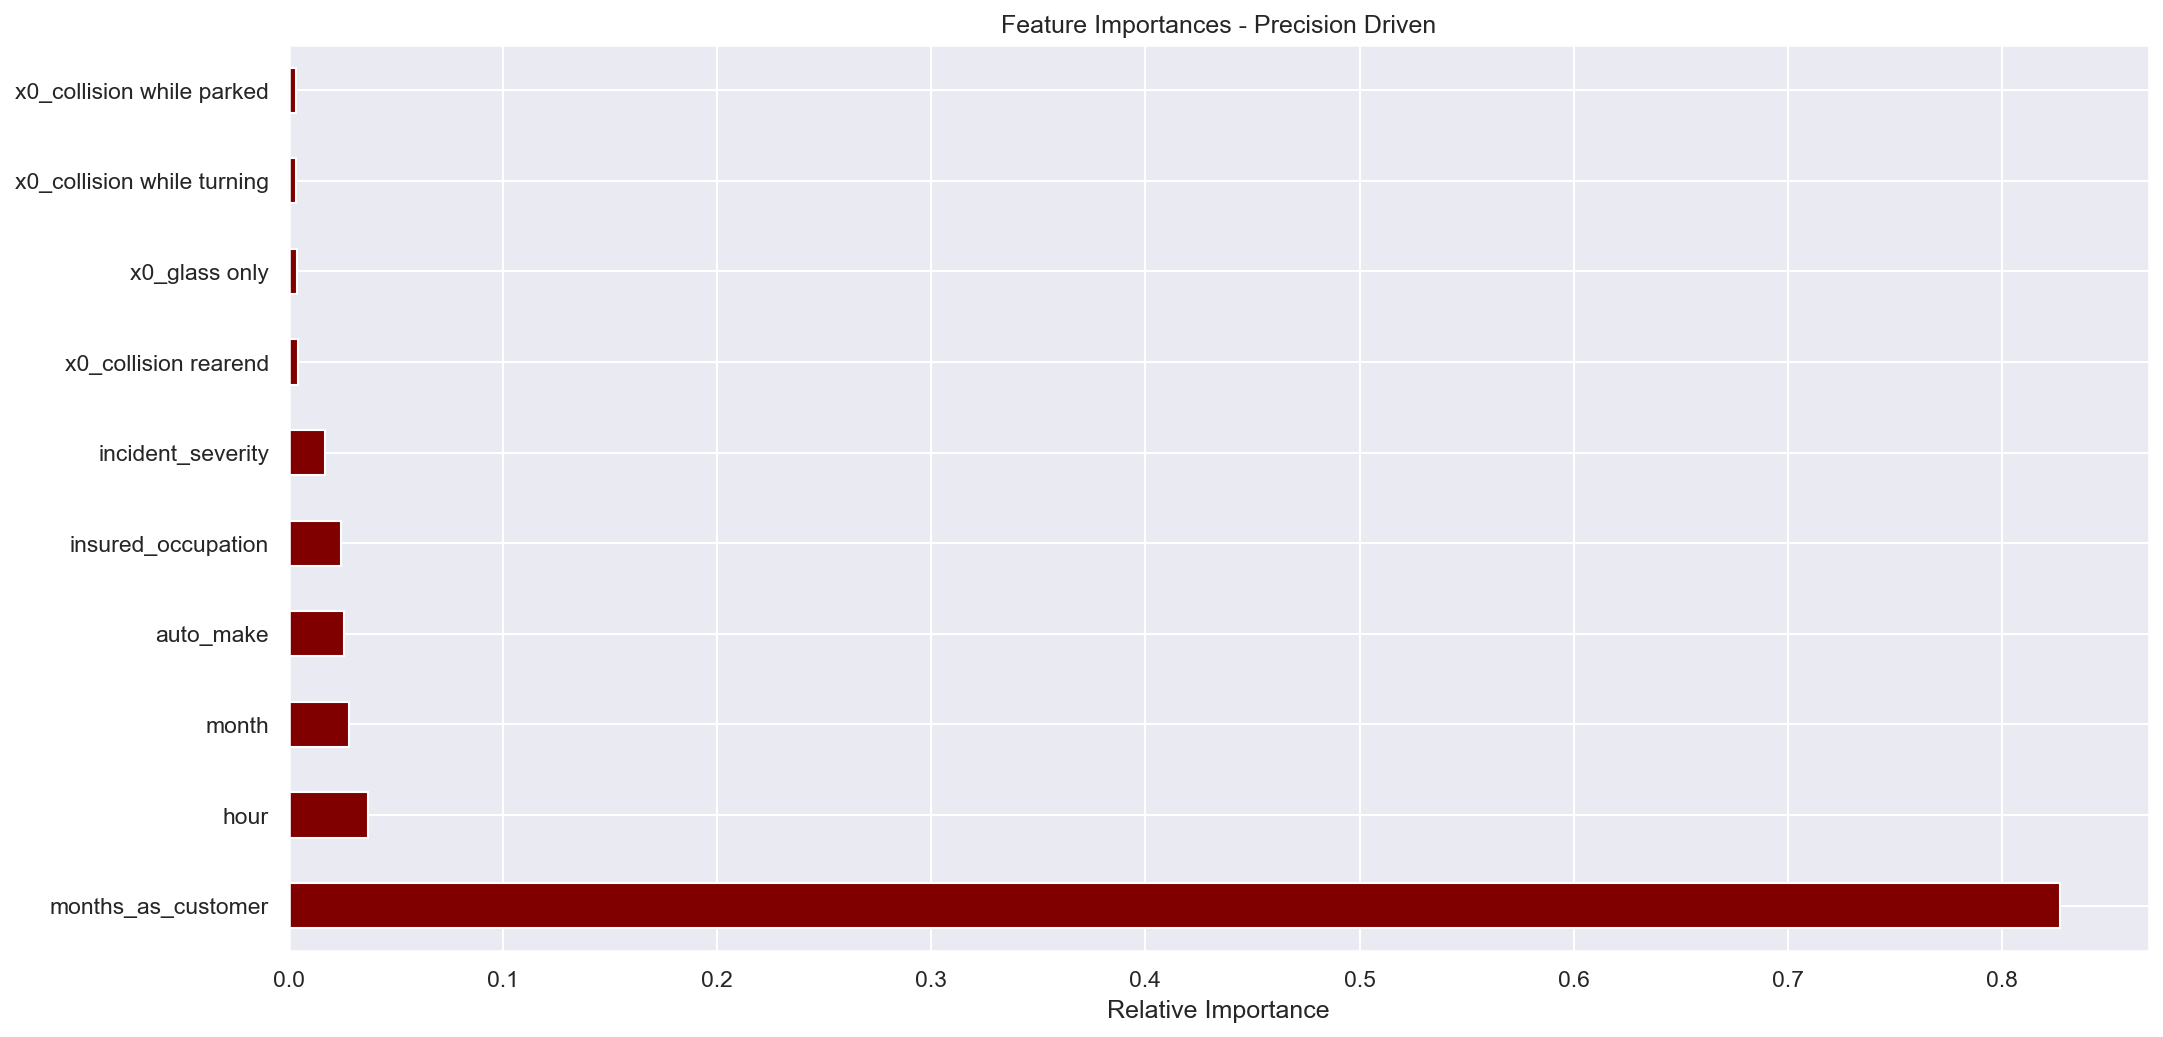

In [46]:
features = np.array(X_train_precision.columns)
plt.title('Feature Importances - Precision Driven')
feat_importances = pd.Series(model_precision.feature_importances_, index=features)
feat_importances.nlargest(10).plot(kind='barh', color = 'maroon')
plt.xlabel('Relative Importance')